In [1]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# =========================
# HYPERPARAMS
# =========================
IMG_SIZE = 224
NUM_CLASSES = 25
BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-3
DATASET_PATH = "/workspace/Data/arcDataset_split"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# =========================
# TRANSFORMS
# =========================
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_ds = datasets.ImageFolder(os.path.join(DATASET_PATH, "train"), transform=train_tf)
val_ds = datasets.ImageFolder(os.path.join(DATASET_PATH, "val"), transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [3]:
# =========================
# CNN BÁSICA
# =========================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28x28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(DEVICE)

In [4]:
# =========================
# LOSS & OPTIMIZER
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [5]:
# =========================
# ENTRENAMIENTO
# =========================
train_losses, val_losses, val_accuracies = [], [], []

start_time_total = time.time()
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    
    # VALIDACIÓN
    model.eval()
    running_loss_val = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss = running_loss_val / len(val_loader.dataset)
    val_acc = accuracy_score(all_labels, all_preds)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Epoch Time: {epoch_time:.2f}s")

total_time = time.time() - start_time_total
print(f"\nTiempo total de entrenamiento: {total_time/60:.2f} minutos")

Epoch 1/30 | Train Loss: 3.2291 | Val Loss: 2.8696 | Val Acc: 0.1806 | Epoch Time: 16.60s
Epoch 2/30 | Train Loss: 2.8088 | Val Loss: 2.6071 | Val Acc: 0.2477 | Epoch Time: 15.35s
Epoch 3/30 | Train Loss: 2.5804 | Val Loss: 2.4247 | Val Acc: 0.2797 | Epoch Time: 16.00s
Epoch 4/30 | Train Loss: 2.3221 | Val Loss: 2.2459 | Val Acc: 0.3560 | Epoch Time: 17.13s
Epoch 5/30 | Train Loss: 2.0829 | Val Loss: 2.1778 | Val Acc: 0.3560 | Epoch Time: 15.49s
Epoch 6/30 | Train Loss: 1.9071 | Val Loss: 2.1767 | Val Acc: 0.3416 | Epoch Time: 15.98s
Epoch 7/30 | Train Loss: 1.6599 | Val Loss: 2.2026 | Val Acc: 0.3509 | Epoch Time: 15.72s
Epoch 8/30 | Train Loss: 1.4330 | Val Loss: 2.1851 | Val Acc: 0.3818 | Epoch Time: 17.17s
Epoch 9/30 | Train Loss: 1.2458 | Val Loss: 2.3222 | Val Acc: 0.3674 | Epoch Time: 16.57s
Epoch 10/30 | Train Loss: 1.0500 | Val Loss: 2.2980 | Val Acc: 0.3736 | Epoch Time: 15.31s
Epoch 11/30 | Train Loss: 0.8794 | Val Loss: 2.4525 | Val Acc: 0.3849 | Epoch Time: 15.56s
Epoch 12

In [6]:
# =========================
# MÉTRICAS COMPLETAS
# =========================
print("\n=================== MÉTRICAS COMPLETAS ===================")
print(f"Accuracy top-1: {accuracy_score(all_labels, all_preds):.4f}")

# top-5 accuracy
top5_correct = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        top5 = outputs.topk(5, dim=1).indices
        top5_correct += sum([labels[i] in top5[i] for i in range(labels.size(0))])
top5_acc = top5_correct / len(val_ds)
print(f"Accuracy top-5: {top5_acc:.4f}")

print("\nCLASIFICATION REPORT:\n")
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=val_ds.classes, zero_division=0))


=================== MÉTRICAS COMPLETAS ===================
Accuracy top-1: 0.3777
Accuracy top-5: 0.7430

CLASIFICATION REPORT:

                                  precision    recall  f1-score   support

         Achaemenid architecture       0.43      0.21      0.29        14
American Foursquare architecture       0.00      0.00      0.00        12
        American craftsman style       0.50      0.41      0.45        39
   Ancient Egyptian architecture       0.83      0.96      0.89        52
           Art Deco architecture       0.22      0.23      0.22        74
        Art Nouveau architecture       0.32      0.58      0.41        90
            Baroque architecture       0.35      0.29      0.32        48
            Bauhaus architecture       0.38      0.16      0.22        19
         Beaux-Arts architecture       0.17      0.13      0.14        39
          Byzantine architecture       0.18      0.09      0.12        23
     Chicago school architecture       0.33      0.13  

<Figure size 1200x1200 with 0 Axes>

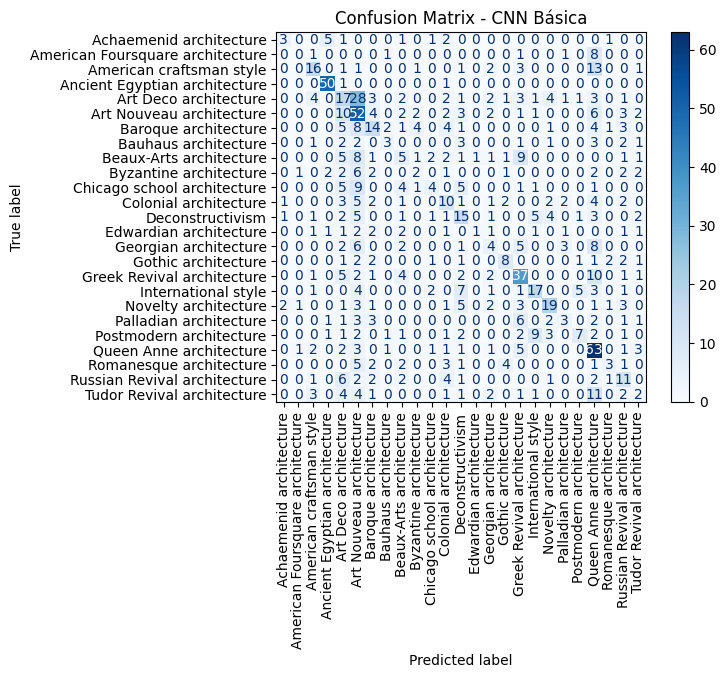

In [7]:
# =========================
# MATRIZ DE CONFUSIÓN
# =========================
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.classes)
plt.figure(figsize=(12,12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix - CNN Básica")
plt.show()

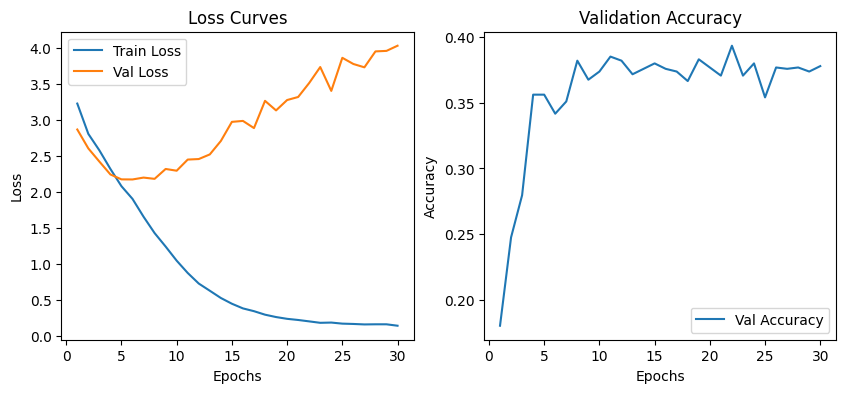

In [8]:
# =========================
# CURVAS DE LOSS / ACCURACY
# =========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1,EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1,EPOCHS+1), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(range(1,EPOCHS+1), val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

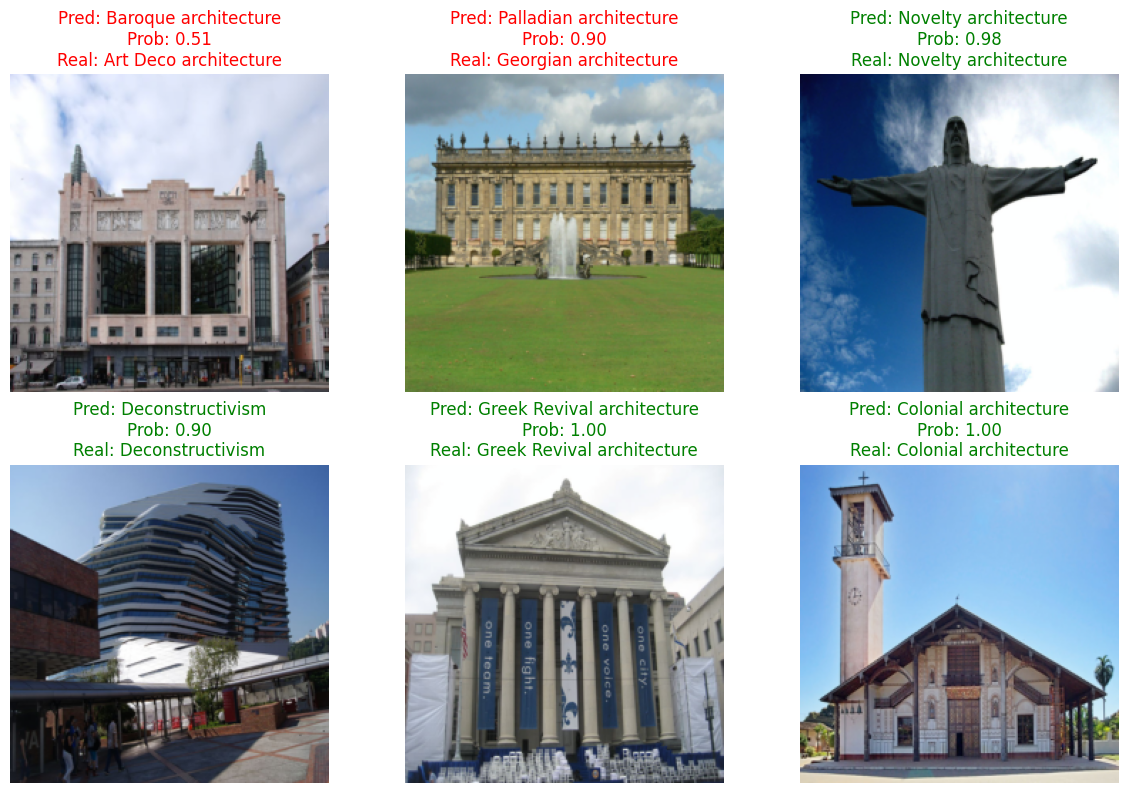

In [9]:
# =========================
# PREDICCIONES REALES
# =========================
def show_predictions(model, dataset, num_images=6):
    model.eval()
    plt.figure(figsize=(12, 8))

    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        img_input = img.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred = model(img_input)
            prob = torch.softmax(pred, dim=1).cpu().numpy()[0]
            pred_class = prob.argmax()
            pred_prob = prob[pred_class]

        img_np = img.permute(1,2,0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(2, 3, i+1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(
            f"Pred: {dataset.classes[pred_class]}\n"
            f"Prob: {pred_prob:.2f}\n"
            f"Real: {dataset.classes[label]}",
            color="green" if pred_class == label else "red"
        )
    plt.tight_layout()
    plt.show()

show_predictions(model, val_ds, num_images=6)

In [10]:
# =========================
# GUARDAR MODELO
# =========================
torch.save(model.state_dict(), "cnn_basica_model.pth")
print("Modelo guardado en cnn_basica_model.pth")

Modelo guardado en cnn_basica_model.pth
